Importaciones

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar

Definicion de variables auxiliares

In [18]:
# Diccionario de mapeo para limpiar nombre de columna del piezometro
# Estructura: sensor_profundidad_variable_unidad
piezo_rename_map = {'depth_m': 'Piezometer_NA_groundwater-depth_m'}

#### Carga y formateo de datos

Formato ancho

In [19]:
# Carga de datos
piezo_df = pd.read_csv(
    '../data/processed/03_daily/piezo-data_SDH1PS01_daily.csv', 
    parse_dates=['Timestamps'], index_col='Timestamps',
    usecols=['Timestamps',
             'depth_m']
    )

soil_df = pd.read_csv(
    '../data/processed/03_daily/soil-data_z6-25818_daily.csv', 
    parse_dates=['Timestamps'], index_col='Timestamps',
    usecols=['Timestamps',
             'TEROS12_15cm_water-content_m3/m3',
             'TEROS12_30cm_water-content_m3/m3',
             'TEROS12_48cm_water-content_m3/m3',
             'TEROS12_15cm_soil-temperature_degree_C',
             'TEROS12_30cm_soil-temperature_degree_C',
             'TEROS12_48cm_soil-temperature_degree_C']
    )

# Renombrado de columnas a partir de diccionario de mapeo
piezo_df = piezo_df.rename(columns=piezo_rename_map)

# Union de datasets en formato ancho
wide_df = pd.merge(piezo_df, soil_df, left_index=True, right_index=True, how='inner')

Formato largo

In [20]:
# Transformacion de datos a formato largo
long_df = wide_df.reset_index().melt(
    id_vars='Timestamps',       # Columna id
    var_name='Metadata',        # Columna temporal en formato sensor_profundidad_variable
    value_name='Value'          # Nombre columna que almacenara los valores 
    )

# Division de la columna de metadatos usando guiones bajos
metadata_split = long_df['Metadata'].str.split('_', expand=True)

# Generacion de nuevas columnas a partir del texto dividido
long_df['Sensor'] = metadata_split[0]
long_df['Depth'] = metadata_split[1]
long_df['Variable'] = metadata_split[2]
long_df['Unit'] = metadata_split[3]

# Eliminacion de la columna metadata
long_df = long_df.drop('Metadata', axis=1)

Auxiliares para visualizacion

In [21]:
# Creacion de columnas de etiquetado (fines esteticos)
long_df['Variable-label'] = long_df['Variable'].map({
    'groundwater-depth': 'Prof. nivel freático (m)',
    'water-content': 'Contenido de agua (m³/m³)',
    'soil-temperature': 'Temperatura (°C)'
})
long_df['Depth-label'] = long_df['Depth'].str.replace('cm', ' cm').replace('NA', 'NA')

# Reorden de columnas en df largo
long_order = ['Timestamps', 'Sensor', 'Depth', 'Depth-label', 'Variable', 'Variable-label', 'Unit', 'Value']
long_df = long_df.reindex(columns=long_order)

# Definicion de listas para ordenar profundidades en graficas
soil_depth_order = ['15 cm', '30 cm', '48 cm']
full_depth_order = ['15 cm', '30 cm', '48 cm', 'NA']


Auxiliares para scatterplot

In [22]:
# Creacion de un df largo sin datos piezometricos
soil_long_df = long_df[long_df['Sensor'] == 'TEROS12'].set_index('Timestamps')

# Creacion de una columna con datos piezometricos
piezo_col = long_df[long_df['Sensor'] == 'Piezometer'].set_index('Timestamps')['Value']

# Union de la columna al df de suelos
scatter_df = soil_long_df.merge(
    piezo_col.rename('Groundwater-depth-m'),
    left_index=True,
    right_index=True)

# Creacion de una columna con el valor del mes
scatter_df['Month'] = scatter_df.index.month


#### Visualizacion

Definicion de estilo de graficos

In [23]:
# Estilo global de seaborn
sns.set_theme(
    context='notebook',     # Escalado para visualizacion web
    style='white',          # Fondo blanco sin ticks en los ejes
    font='sans-serif'
    )

# Grillas
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Paleta de colores
viridis = sns.color_palette("viridis_r", n_colors=3)
palette_dict = {
    '15 cm': viridis[0],    # Verde claro
    '30 cm': viridis[1],    # Verde azulado
    '48 cm': viridis[2],    # Azul
    'NA': 'black'           # Negro
}

##### Series temporales

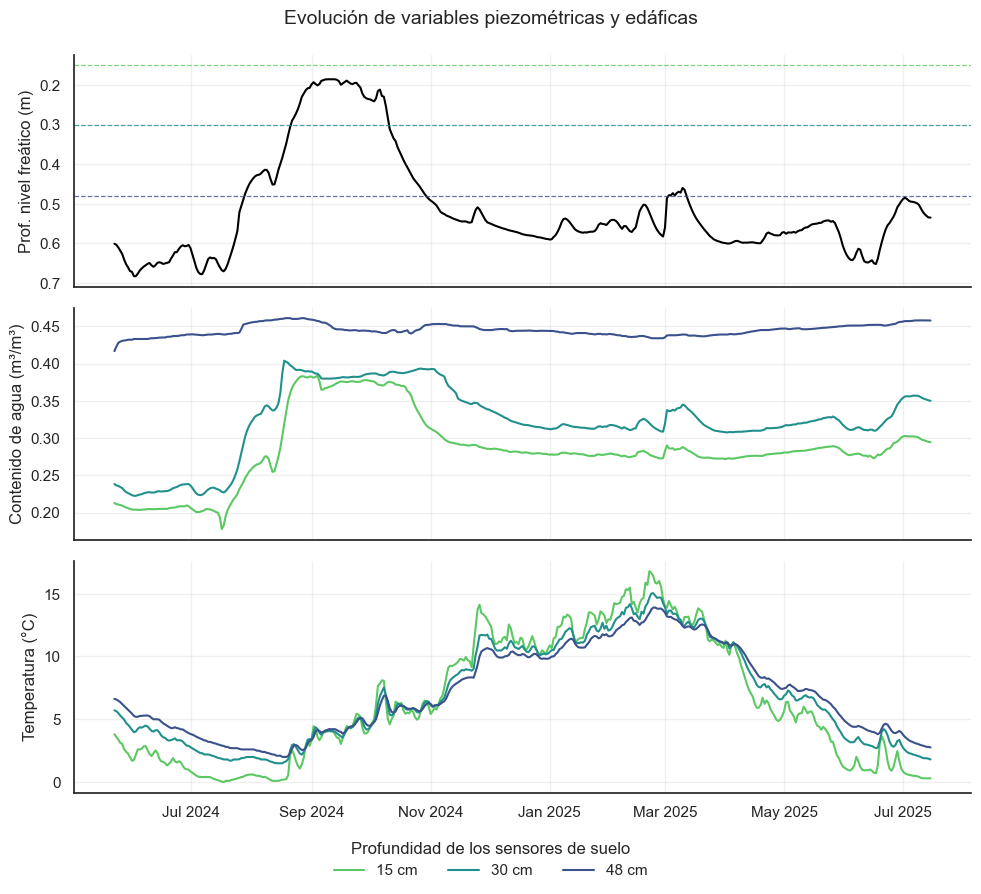

In [24]:
# Creacion de la figura base
time_series = sns.relplot(
    data=long_df,
    x='Timestamps',
    y='Value',
    hue ='Depth-label',             # Diferencia colores segun profundidad
    row='Variable-label',           # Una fila por cada variable
    palette=palette_dict,
    hue_order=full_depth_order,
    kind='line',                    # Grafico de lineas
    height=3,
    aspect=3,
    facet_kws={'sharey': False, 'sharex':True}      # Eje Y independiente, eje X compartido
)

# Eliminacion de elementos incluidos por defecto
time_series.set_titles('')
time_series.set_xlabels('')
time_series._legend.remove()

# Iteracion sobre facets para aplicar estilos particulares
for i, (ax, title) in enumerate(zip(time_series.axes.flat, time_series.row_names)):

    # Etiquetado de los ejes Y de cada facet
    ax.set_ylabel(title, fontweight='normal')

    # Formateo de fechas en el eje X
    date_format = mdates.DateFormatter('%b %Y')
    ax.xaxis.set_major_formatter(date_format)

    # Configuracion particular para el primer facet
    if 'Prof. nivel freático (m)' in title:
        
        # Invierte el eje Y
        ax.invert_yaxis()

        # Traza profundidad de sensores de suelo como lineas horizontales
        sensor_depths_m = [0.15, 0.30, 0.48]
        for depth, label in zip(sensor_depths_m, soil_depth_order):
            ax.axhline(y=depth, color=palette_dict[label], linestyle='--', linewidth= 0.9, alpha=0.8)

# Eliminacion de la leyenda de objetos asociados al piezometro
handles, labels = time_series.axes[0,0].get_legend_handles_labels()
clean_handles = [h for h, l in zip(handles, labels) if l != 'NA']
clean_labels = [l for l in labels if l != 'NA']

# Creacion de nueva leyenda
time_series.figure.legend(
    handles=clean_handles,
    labels=clean_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    ncol=3,
    title="Profundidad de los sensores de suelo",
    frameon=False
)

# Establecimiento de titulo
time_series.figure.suptitle("Evolución de variables piezométricas y edáficas",
                            x=0.5, y=0.98, fontsize=14)

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.11) # Ajusta espacio disponible para facets

plt.show()

##### Correlaciones cruzadas

##### Graficos de dispersion mensuales

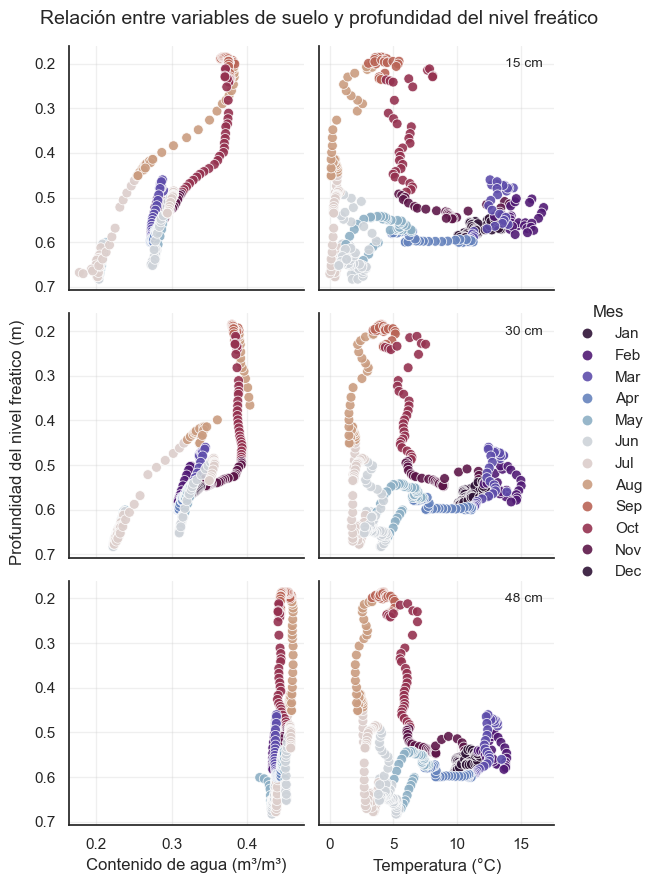

In [25]:
# Creacion de la figura base
scatter_plot = sns.relplot(
    data=scatter_df,
    x='Value',                          # Eje X: variables de suelo
    y='Groundwater-depth-m',            # Eje Y: profundidad nivel freatico
    hue='Month',                        # Coloreado por mes
    row='Depth-label',                  # Una fila por profundidad
    col='Variable-label',               # Una columna por variable
    row_order=soil_depth_order,
    palette='twilight_shifted',         # Paleta ciclica
    kind='scatter',
    height=3,
    aspect=1,
    facet_kws={'sharey': True, 'sharex': 'col'},    # Eje Y compartido, Eje X: compartido por columnas
    s=50,
    alpha=0.9,
    legend='full'
)

# Eliminacion de elementos incluidos por defecto
scatter_plot.set_titles('')
scatter_plot.set_xlabels('')
scatter_plot.set_ylabels('')

# Etiquetado del eje X
scatter_plot.axes[-1, 0].set_xlabel("Contenido de agua (m³/m³)")
scatter_plot.axes[-1, 1].set_xlabel("Temperatura (°C)")

# Inversion del eje Y (+ margen)
y_min, y_max = scatter_df['Groundwater-depth-m'].min(), scatter_df['Groundwater-depth-m'].max()
padding = (y_max - y_min) * 0.05
scatter_plot.set(ylim=(y_max + padding, y_min - padding))

# Etiquetado del eje Y
scatter_plot.figure.supylabel(
    'Profundidad del nivel freático (m)',
    x=0.04,
    size=plt.rcParams['axes.labelsize'], # Igualar tamaño al eje X
    )

# Titulo de leyenda
legend = scatter_plot._legend
legend.set_title('Mes')

# Etiquetado de meses en leyenda
month_names = {str(i): calendar.month_abbr[i] for i in range(1, 13)}
for t in legend.texts:
    if t.get_text() in month_names:
        t.set_text(month_names[t.get_text()])


# Iteracion sobre los facets para agregar etiqueta de profundidad
for ax, label in zip(scatter_plot.axes[:, -1], soil_depth_order):
    ax.text(
        x=0.95,
        y=0.95,
        s=f'{label}',
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=10,
    )

# Establecimiento de titulo
scatter_plot.figure.suptitle("Relación entre variables de suelo y profundidad del nivel freático",
                             x=0.5, y=0.98, fontsize=14)

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.94, right=0.85) # Ajusta espacio disponible para facets

plt.show()